# Attempt: Transfer Learning with InceptionResNet and Data Augmentation

In [1]:
import pandas as pd
import numpy as np
from time import time
import datetime
import tensorflow as tf
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K

%matplotlib inline
print(tf.keras.__version__)
print(K.tensorflow_backend._get_available_gpus())

SEED = 42
SESSION_NAME = datetime.datetime.now().strftime("%Y%m%d-%H%M")
PI = tf.constant(np.pi)


Using TensorFlow backend.


2.1.6-tf
['/job:localhost/replica:0/task:0/device:GPU:0']


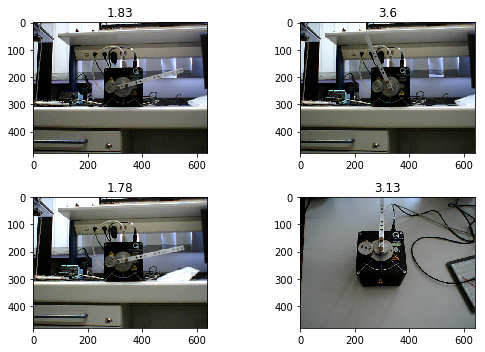

In [2]:
traindf=pd.read_csv("./labels_all.csv",dtype={'id': str, 'label_rad': np.float32, 'label_scaled': np.float32, 'label_sin': np.float32, 'label_cos': np.float32})

#Visualizing some Examples
IMG_PATH = "images/"
fig = plt.figure(figsize=(10,5))
for i in range (1, 5):
    a = fig.add_subplot(2, 2, i)
    imgplot = plt.imshow(mpimg.imread(IMG_PATH+traindf.iloc[(i*5000)-1]['id']), cmap='gray', vmin=0, vmax=1)
    a.set_title(traindf.iloc[(i*5000)-1]['label_rad']) 
    plt.tight_layout()

Found 54925 images.
Found 554 images.


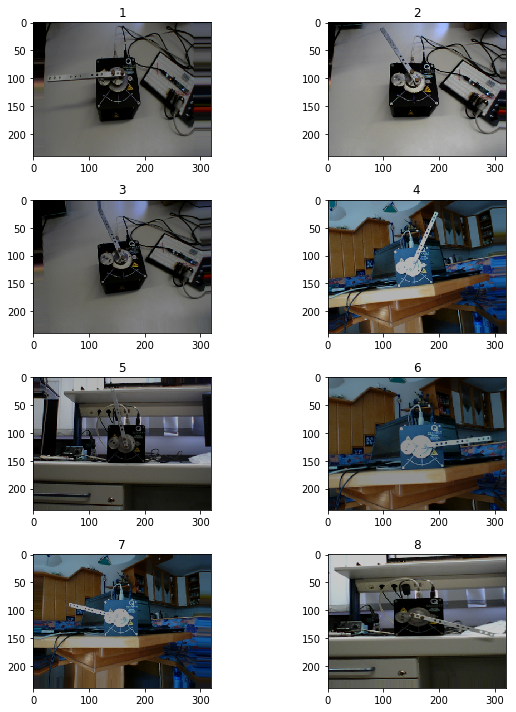

In [3]:
# Input constants
HEIGHT = 480
WIDTH = 640
TARGET_HEIGHT = 240
TARGET_WIDTH = 320
CHANNELS = 3
BATCH_SIZE = 8
VAL_SPLIT = 0.01
NUM_IMAGES = 55479
NUM_TRAIN_IMAGES = NUM_IMAGES*(1-VAL_SPLIT)
NUM_VAL_IMAGES = NUM_IMAGES*VAL_SPLIT

datagen = keras.preprocessing.image.ImageDataGenerator(validation_split=VAL_SPLIT,
                                                       rescale = 1/256,
                                                       width_shift_range = 10,
                                                       height_shift_range = 10,
                                                       rotation_range = 5,
                                                       brightness_range = [0.5, 1.5],
                                                       zoom_range = 0.2)

train_generator = datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=IMG_PATH,
                                                    x_col="id",
                                                    y_col="label_scaled",
                                                    subset="training",
                                                    seed=SEED,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode="other",
                                                    target_size=(TARGET_HEIGHT,TARGET_WIDTH),
                                                    color_mode = "rgb")

val_generator = datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=IMG_PATH,
                                                    x_col="id",
                                                    y_col="label_scaled", #evt. None
                                                    subset="validation",
                                                    seed=SEED,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode="other", #evt. None
                                                    target_size=(TARGET_HEIGHT,TARGET_WIDTH),
                                                    color_mode = "rgb")

fig = plt.figure(figsize=(12,10))
for X_batch, y_batch in train_generator:
    for i in range(1, 9):
        image = ((X_batch[i-1]*256).astype('uint8'))#[:,:,0]
        a = fig.add_subplot(4, 2, i)
        imgplot = plt.imshow(image, cmap='gray', vmin = 0, vmax = 256)
        a.set_title("{}".format(i))
        plt.tight_layout()
    break

In [8]:
#Objective Function
def scaled_squared_angdiff(y_true, y_pred):
    y_true_scaled = y_true*PI #Heftiger Bug!
    y_pred_scaled = y_pred*PI #Heftiger Bug!
    delta = tf.atan2(tf.sin(y_pred_scaled-y_true_scaled), tf.cos(y_pred_scaled-y_true_scaled))
    loss = tf.square(delta)
    return loss

## Achtung Bug!
y_true und y_pred falsch scaliert!
beide müssen mit 2Pi und nicht Pi multipliziert werden.
atan2 liefert dann natürlich falsche ergebnisse!

In [4]:
#Model Definition
model = Sequential()
model.add(InceptionResNetV2(include_top=False,
                            weights='imagenet',
                            input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3),
                            pooling='avg'))
model.add(Dense(128, activation="elu"))
model.add(Dropout(0.05, seed=SEED))
model.add(Dense(64, activation="elu"))
model.add(Dense(1, activation="linear"))

model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 54,541,793
Trainable params: 205,057
Non-trainable params: 54,336,736
_________________________________________________________________


In [9]:
# Training constants
NUM_EPOCHS = 12
LEARNING_RATE = 0.0003
DECAY = 1e-6

FILEPATH_SAVE='checkpoints/{}_model_weights.h5'.format(SESSION_NAME)
checkpoint = keras.callbacks.ModelCheckpoint(FILEPATH_SAVE,
                                             monitor=["mae"],
                                             verbose=1,
                                             mode='max')

#Tensorboard Callback
FILEPATH_TENSORBOARD_LOG = 'logdir/{}'.format(SESSION_NAME)
tensorboard = keras.callbacks.TensorBoard(log_dir = FILEPATH_TENSORBOARD_LOG,
                                          write_images=True,
                                          batch_size=BATCH_SIZE,
                                          write_graph=True,
                                         )

model.compile(optimizer='adam', #keras.optimizers.rmsprop(lr=LEARNING_RATE, decay=DECAY),
                loss=scaled_squared_angdiff,
                metrics=['mae', scaled_squared_angdiff])

#starting Tensorboard:
#tensorboard --logdir=C:\Users\Laurenz\Desktop\Vision_Control_Laurenz\vision_control\Development\Laurenz\dataframe_tutorial\logdir\ --host localhost --port 8088
#Navigated the browser to http://localhost:8088
#%tensorboard --logdir=logdir/ --host localhost --port 8088

In [ ]:
history = model.fit_generator(train_generator, 
                               epochs=NUM_EPOCHS,
                               workers=4, 
                               steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE, 
                               validation_data = val_generator,
                               validation_steps = NUM_VAL_IMAGES // BATCH_SIZE,
                               shuffle=True,
                               callbacks=[tensorboard, checkpoint])

Epoch 1/12
6865/6865 [==============================] - 3973s 579ms/step - loss: 0.6590 - mean_absolute_error: 2.0105 - scaled_squared_angdiff: 0.6590 - val_loss: 1.0712 - val_mean_absolute_error: 2.1914 - val_scaled_squared_angdiff: 1.0712

Epoch 00001: saving model to checkpoints/20190711-0923_model_weights.h5
Epoch 2/12
6865/6865 [==============================] - 4187s 610ms/step - loss: 0.4201 - mean_absolute_error: 2.0001 - scaled_squared_angdiff: 0.4201 - val_loss: 0.8285 - val_mean_absolute_error: 2.1107 - val_scaled_squared_angdiff: 0.8285

Epoch 00002: saving model to checkpoints/20190711-0923_model_weights.h5
Epoch 3/12
6865/6865 [==============================] - 4153s 605ms/step - loss: 0.3501 - mean_absolute_error: 1.9999 - scaled_squared_angdiff: 0.3501 - val_loss: 0.8207 - val_mean_absolute_error: 1.8934 - val_scaled_squared_angdiff: 0.8207

Epoch 00003: saving model to checkpoints/20190711-0923_model_weights.h5
Epoch 4/12
6865/6865 [==============================] - 44

## Observations and Things to Improve:
--------------------------------------
+ 12 epochs for >50k takes way to much time for experimentation
+ 1 or 2 epochs for testing should be enough!
+ tensorboard should update on every batch!
+ mean absolute error not necessary
+ enable early stopping


In [5]:
#load model due to termination of training
model.load_weights("checkpoints/20190711-0923_model_weights.h5")

In [31]:
pred=model.predict_generator(val_generator,
                            #steps=NUM_VAL_IMAGES // BATCH_SIZE,
                            verbose=1)

70/70 [==============================] - 23s 325ms/step


In [32]:
filenames=val_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":pred.tolist()})
results.to_csv("results_{}.csv".format(SESSION_NAME),index=False)

In [33]:
results.head()

,Filename,Predictions
0,1562172602.695782_2.45.png,[2.4465785026550293]
1,1562172602.9665918_2.54.png,[2.555047035217285]
2,1562172603.2289443_2.65.png,[2.5582313537597656]
3,1562172603.4804783_2.72.png,[2.5443966388702393]
4,1562172603.8133502_2.83.png,[2.0664258003234863]


## Results
---------------------
+ Predictions have a wider range as the usual PI, but are still very limited in Range [2.0 - 2.5]
+ Try different Model architectures with different sizes and experiment with sin/cos output or shifting [0 - 1] to [-0.5 - 0.5]